In [1]:
from functools import reduce
from operator import add

import numpy as np
import pandas as pd

In [2]:
Z_with_import = False
Y_with_import = False
include_imports = True

# SRIO

## Z: Inter-industry transactions of intermediate products (unit: €/year)

Intermediate products: goods and services as inputs in the production processes.

In [3]:
# Z (unit: Million euro)
Z_columns = [
    'Agriculture',
    'Industry',
    'EHP',
    'RoService'
]

Z_values_NL = [
    [1053, 16373, 170, 787],
    [3745, 88955, 11478, 37202],
    [194, 2757, 6868, 7736],
    [6580, 83484, 30315, 194654]
]

Z_values = Z_values_NL

Z = pd.DataFrame(Z_values, index=Z_columns, columns=Z_columns)
Z

,Agriculture,Industry,EHP,RoService
Agriculture,1053,16373,170,787
Industry,3745,88955,11478,37202
EHP,194,2757,6868,7736
RoService,6580,83484,30315,194654


Q1: What does the value in cell C8 (3,0) tell you? (2 points)  

In year 2019, Dutch Agriculture purchased 6580 milliion euros worth of RoService products for production.  
//  
The monetary transaction flow (in Million euro) supplied by the (domestic) "Rest of Services" sector and purchased by the (domestic) Agriculture sector 

## Y: Final demand (unit: €/year)

In [4]:
# Y (unit: Million euro)
Y_columns = ['Domestic', 'Export']

Y_values_NL = [
    [2257, 12790],
    [127940, 224817],
    [176644, 8246],
    [291297, 162090],
]

Y_values = Y_values_NL

Y = pd.DataFrame(Y_values, index=Z_columns, columns=Y_columns)
Y

,Domestic,Export
Agriculture,2257,12790
Industry,127940,224817
EHP,176644,8246
RoService,291297,162090


In [5]:
tot_FD_Domestic = Y['Domestic'].sum()
tot_FD_Domestic

598138

Q2: What does the column sum of FD_Domestic tell you? (2 points)  

Dutch final consumption of domestic products in 2019 totaled 598138 million euros.

## x: Gross output (unit: €/year)

Gross output of Sector j: intermediate products + finished products of Sector j

In [6]:
# x (unit: Million euro)
x = Z.sum(axis=1) + Y.sum(axis=1)
x

Agriculture     33430
Industry       494137
EHP            202445
RoService      768420
dtype: int64

## V: Value added (unit: €/year)

- Economic gains generated by producing goods and services.
- Main components: wages, taxes minus subsidies, capital profits, etc
- v: value added pet unit per year
- V: value added per year

In [7]:
# v (Unit: Million euro/Million euro)
v_values_NL = [0.472, 0.361, 0.691, 0.62]

v_values = v_values_NL

v = pd.Series(v_values, index=Z_columns)
v

Agriculture    0.472
Industry       0.361
EHP            0.691
RoService      0.620
dtype: float64

In [8]:
# V (Unit: Million euro)
# method 1
V = x.mul(v)
V

Agriculture     15778.960
Industry       178383.457
EHP            139889.495
RoService      476420.400
dtype: float64

In [9]:
# !!! method 2: required to have calculated M import
# See below
# V2 = x - Z.sum(axis=1) - M_INT.sum(axis=1)
# V2

Q3: Calculate V; Which sector is more profitable and why?  

From a per unit perspective, EHP is the most profitable (see v). 
RoService created the largest value added in the Swiss economy in 2019 (see V).

## M: Import (unit: €/year)

Import: both intermediate products for production purposes and finished products

In [10]:
# M (Unit: Million euro/Million euro)
M_INT_NL_values = [
    [1887, 6882, 503, 935],
    [2880, 100596, 6829, 16386],
    [8, 85, 59, 176],
    [1298, 16587, 6243, 34499]
]

M_INT_values = M_INT_NL_values

M_INT = pd.DataFrame(M_INT_values, index=Z_columns, columns=Z_columns)
M_INT

,Agriculture,Industry,EHP,RoService
Agriculture,1887,6882,503,935
Industry,2880,100596,6829,16386
EHP,8,85,59,176
RoService,1298,16587,6243,34499


In [11]:
M_FD_NL_values = [9069, 97315, 1550, 19656]

M_FD_values = M_FD_NL_values

M_FD = pd.DataFrame(M_FD_values, index=Z_columns, columns=[Y_columns[0]])
M_FD

,Domestic
Agriculture,9069
Industry,97315
EHP,1550
RoService,19656


### Recalculate Z to include import

In [12]:
if include_imports and not Z_with_import:
    Z = Z + M_INT
    Z_with_import = True
Z

,Agriculture,Industry,EHP,RoService
Agriculture,2940,23255,673,1722
Industry,6625,189551,18307,53588
EHP,202,2842,6927,7912
RoService,7878,100071,36558,229153


### Recalculate Y to include import

In [13]:
if include_imports and not Y_with_import:
    Y = Y.add(M_FD, fill_value=0)
    Y_with_import = True
Y

,Domestic,Export
Agriculture,11326,12790.0
Industry,225255,224817.0
EHP,178194,8246.0
RoService,310953,162090.0


## A: Technical coefficient (unit: €/€)

$$a_{i,j} = z_{i,j}/x_j$$
$$z_{i,j} = a_{i,j} x_j$$

$aij$ : direct requirements of sector i per € output of sector j  
$lij$ : total requirements of sector i per € final demand of sector j

In [14]:
# A (Unit: Million euro/Million euro)
A = Z.divide(x.T)  # Z = A.mul(x)
A.round(3)

,Agriculture,Industry,EHP,RoService
Agriculture,0.088,0.047,0.003,0.002
Industry,0.198,0.384,0.090,0.070
EHP,0.006,0.006,0.034,0.010
RoService,0.236,0.203,0.181,0.298


In [15]:
Id = pd.DataFrame(np.identity(len(Z_columns)), index=A.index, columns=A.columns)
Id

,Agriculture,Industry,EHP,RoService
Agriculture,1.0,0.0,0.0,0.0
Industry,0.0,1.0,0.0,0.0
EHP,0.0,0.0,1.0,0.0
RoService,0.0,0.0,0.0,1.0


## L: Leontief inverse
### by inverse

$Z + y = x$  
$Ax + y = x$  
$y = (I-A)x$  
$(I-A)^{-1}(I-A)x=(I-A)^{-1}y$  

$x = (I-A)^{-1}y = Ly$

$lij$ : total requirements of sector i per € final demand of sector j

In [16]:
(Id - A)

,Agriculture,Industry,EHP,RoService
Agriculture,0.912055,-0.047062,-0.003324,-0.002241
Industry,-0.198175,0.616400,-0.090429,-0.069738
EHP,-0.006042,-0.005751,0.965783,-0.010296
RoService,-0.235657,-0.202517,-0.180582,0.701787


In [17]:
L = pd.DataFrame(np.linalg.inv((Id - A).values), A.columns, A.index)
L.round(2)

,Agriculture,Industry,EHP,RoService
Agriculture,1.12,0.09,0.01,0.01
Industry,0.42,1.71,0.19,0.17
EHP,0.01,0.02,1.04,0.02
RoService,0.50,0.53,0.33,1.48


### by series expansion

L covers supply chains of inifinte lengths. Power expansions stops at a certain depth

$$(I-A)^{-1} = I + A + A^2 + A^3 + ... + A^n + ... = \lim_{n \to +\infty} \sum_{k=0}^{n} A^k$$

The power series converges only under certain conditions:
- A ≥ 0 (coefficients matrix contains only non-negative terms)
- The system produces more output than it requires inputs N(A) < 1
- |I − A| > 0
- More generally, the [Hawkins-Simon conditions](https://www.wikiwand.com/en/Hawkins%E2%80%93Simon_condition)

the limit sum convergs if all of the eigenvalues of A have absolute value smaller than 1 (?)

In [18]:
# AA
A.dot(A).round(4)

,Agriculture,Industry,EHP,RoService
Agriculture,0.0176,0.0227,0.0051,0.0042
Industry,0.1104,0.1711,0.0510,0.0489
EHP,0.0043,0.0048,0.0036,0.0038
RoService,0.1322,0.1502,0.0791,0.1054


In [19]:
# AAA
A.dot(A.dot(A)).round(4)

,Agriculture,Industry,EHP,RoService
Agriculture,0.0071,0.0104,0.0030,0.0029
Industry,0.0555,0.0810,0.0264,0.0273
EHP,0.0023,0.0028,0.0013,0.0015
RoService,0.0667,0.0857,0.0358,0.0430


In [20]:
def leontief_power_series(A_mat, depth):
    Id_mat = pd.DataFrame(np.identity(len(Z_columns)), index=A.index, columns=A.columns)
    
    res = [None]*(depth+1)
    res[0] = Id_mat

    for i in range(1, depth+1):
        res[i] = res[i-1].dot(A_mat)
        print(f"{'A'*i}\n{res[i]}\n\n")

    return reduce(add, res)

In [21]:
leontief_power_series(A, 3)

A
             Agriculture  Industry       EHP  RoService
Agriculture     0.087945  0.047062  0.003324   0.002241
Industry        0.198175  0.383600  0.090429   0.069738
EHP             0.006042  0.005751  0.034217   0.010296
RoService       0.235657  0.202517  0.180582   0.298213


AA
             Agriculture  Industry       EHP  RoService
Agriculture     0.017609  0.022665  0.005067   0.004182
Industry        0.110429  0.171119  0.051035   0.048923
EHP             0.004304  0.004773  0.003570   0.003837
RoService       0.132226  0.150208  0.079128   0.105442


AAA
             Agriculture  Industry       EHP  RoService
Agriculture     0.007056  0.010399  0.003037   0.002919
Industry        0.055461  0.081039  0.026422   0.027296
EHP             0.002250  0.002831  0.001261   0.001524
RoService       0.066722  0.085651  0.035771   0.043030




,Agriculture,Industry,EHP,RoService
Agriculture,1.112610,0.080125,0.011428,0.009342
Industry,0.364065,1.635758,0.167887,0.145957
EHP,0.012597,0.013355,1.039048,0.015658
RoService,0.434604,0.438376,0.295481,1.446685


### demand driven/pull vs supply sided

$x* = (I-A)^{-1}y*$ 

The demand-driven (or demand pull) version of the open Input-Output model determines production as a function of final demand, given the production technology.  
- $y*$ represents a certain final demand of finished goods and services
- $x*$ represents all sectors' outputs (products/services) directly and indirectly required to fullfill the final demand for $y*$


$x = (I-A)^{-1}y$

On the contrary, in the supply-sided version, value added determines output and producers must induce sales in order to achieve a desired level of income.

$Iy*$  
direct impact  

$(A + A^2 + A^3 + ... + A^n)y*$  
indirect supply chain impact for n level/rounds


$Iy*$ 

In [22]:
# Demand pull
y_star_index = 'Industry'

y_star = pd.Series(np.array(x.index == y_star_index, dtype=int), index=x.index)
y_star

Agriculture    0
Industry       1
EHP            0
RoService      0
dtype: int64

In [23]:
# Ay*
A.dot(y_star).round(3)

Agriculture    0.047
Industry       0.384
EHP            0.006
RoService      0.203
dtype: float64

In [24]:
# AAy*
A.dot(A.dot(y_star)).round(3)

Agriculture    0.023
Industry       0.171
EHP            0.005
RoService      0.150
dtype: float64

In [25]:
# AAAy*
A.dot(A.dot(A.dot(y_star))).round(3)

Agriculture    0.010
Industry       0.081
EHP            0.003
RoService      0.086
dtype: float64

In [26]:
def demand_pull_power_series(y_st, A_mat, depth):
    res = [y_st]*(depth+1)
    for i in range(1, depth+1):
        res[i] = A_mat.dot(res[i-1])

    res = pd.concat(res, axis=1)
    res.columns = ['A'*i + 'y*' for i in range(depth+1)]
    res['sum'] = res.sum(axis=1)
    return res

In [27]:
demand_pull_power_series(y_star, A, 3).round(3)

,y*,Ay*,AAy*,AAAy*,sum
Agriculture,0,0.047,0.023,0.010,0.080
Industry,1,0.384,0.171,0.081,1.636
EHP,0,0.006,0.005,0.003,0.013
RoService,0,0.203,0.150,0.086,0.438


Compare the power expansion with using Leontief inverse directly

In [28]:
L.dot(y_star)

Agriculture    0.089771
Industry       1.713420
EHP            0.016403
RoService      0.528812
dtype: float64

## F/f: Footprint (in Tonne / euros)

$$f_i = F_i / x_i$$  

- F: (direct) emissions, resource use, etc.
- f: (direct) environmental coefficients

$$fAx + fy = fx = fLy$$  

- $fAx$: environmental pressure (EP) directly generated while producing the intermediate products
- $fy$: environmental pressure (EP) directly generated while producing the finished products
- $fx$: environmental pressure (EP) directly generated while producing all products (intermediate + finished)
- $fLy$: environmental pressure (EP) directly and inderectly generated to meet the final demand


$$f_{\text{total}} = f_{\text{direct}}L$$

In [29]:
# F (Unit: Million tonne)
F_values_NL = [13.9, 92.7, 2.3, 44.7]

F_values = F_values_NL

F = pd.Series(F_values, index=Z_columns)
F

Agriculture    13.9
Industry       92.7
EHP             2.3
RoService      44.7
dtype: float64

`f_direct` is a row vector of wage, job, value added, CO2 emissions, water use ... per
unit gross output. Direct environmental pressures intensity 

In [30]:
# f (Unit: tonne)
# Note: f's unit is Tonne/Million euro. If measured in Million tonne/Million euro, i.e., tonne/euro, the numbers will appear too small to report. 
# coeff = F_unit / f_unit
coeff = 1_000_000

f_direct = F.divide(x)*coeff
f_direct

Agriculture    415.794197
Industry       187.599795
EHP             11.361110
RoService       58.171313
dtype: float64

In [31]:
f_total = f_direct.dot(L)
f_total

Agriculture    573.227365
Industry       389.711699
EHP             73.510590
RoService      124.525669
dtype: float64

In [32]:
# aggregate Footprint (in tonne)
f_total.dot(Y['Domestic'])

146097658.33842105

In [33]:
# We can diagonlise the FD domestic to get more granular info
Y_domestic = Y['Domestic'].mul(Id)
Y_domestic

,Agriculture,Industry,EHP,RoService
Agriculture,11326.0,0.0,0.0,0.0
Industry,0.0,225255.0,0.0,0.0
EHP,0.0,0.0,178194.0,0.0
RoService,0.0,0.0,0.0,310953.0


In [34]:
# GHG Footprint (Unit: Million tonne)
# coeff = f_unit / Footprint_unit
coeff = 1/1_000_000

Footprint = f_total.dot(Y_domestic)*coeff
Footprint

Agriculture     6.492373
Industry       87.784509
EHP            13.099146
RoService      38.721630
dtype: float64

In [35]:
# and we get the same result (modulo a million)
Footprint.sum()

146.09765833842107

### Production based vs Consumption based

EF represents supply chain-wide environmental pressures generated by a nation’s final demand (Footprint)

- Production-based accounting (PBA) $EF = fx + F\_Y$
  - conventional perspective
  - direct
  - territorial
- Consumption-based accounting (CBA) $EF = fLy + F\_Y$
  - direct effects are ultimately attributable to the final demand
  - direct + indirect
  - footprint

             PBA (territorial)  CBA (footprint)
Agriculture               13.9         6.492373
Industry                  92.7        87.784509
EHP                        2.3        13.099146
RoService                 44.7        38.721630
             PBA (territorial)  CBA (footprint)
Agriculture           0.090495         0.044439
Industry              0.603516         0.600862
EHP                   0.014974         0.089660
RoService             0.291016         0.265039


<AxesSubplot:>

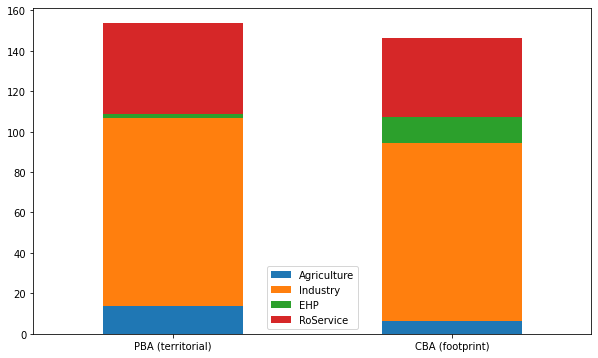

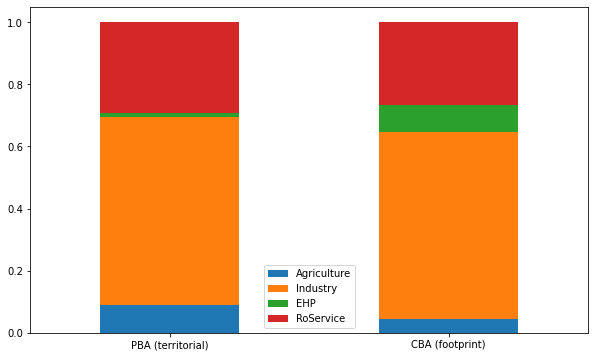

In [36]:
df_cba_pba = pd.concat([F, Footprint], axis=1).rename(
    {0: 'PBA (territorial)', 1: 'CBA (footprint)'}, axis=1)

df_cba_pba_percent = df_cba_pba/df_cba_pba.sum()

print(df_cba_pba)
print(df_cba_pba_percent)

df_cba_pba.T.plot.bar(figsize=(10,6), stacked=True, rot=0)
df_cba_pba_percent.T.plot.bar(figsize=(10,6), stacked=True, rot=0)

### With / Without emission from final consumers

$$EF = f_{\text{total}}y + F\_Y = f_{\text{direct}}Ly + F\_Y$$

- y doesn’t include export because the environmental pressures generated when producing exported goods and services = other countries’ footprint
- For an open economy $EF \neq F$
- For a closed economy: $f_{\text{total}}y = f_{\text{direct}}Ly = f_{\text{direct}}x = F$

In [37]:
# F_Y (Unit: million tonne)
F_Y_NL = 36.1

F_Y = F_Y_NL

In [38]:
# EF (Unit: Million tonnes)
EF = Footprint.sum() + F_Y
EF

182.19765833842106

### With / Without imports

1. modify `include_imports`
2. cache result of footprint
3. comment footprint
4. restart from begining (starting from SRIO)

In [39]:
# include_imports = True
# Footprint_without_import = Footprint
# Footprint_with_import = Footprint

In [40]:
# df_srio = pd.concat([Footprint, Footprint_with_import], axis=1).rename(
#     {0: 'without import', 1: 'with_import'}, axis=1)

# print(df_srio)

# df_srio.T.plot.bar(figsize=(10,6), stacked=True, rot=0)